In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir=repo+"/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
simnum=101

In [5]:
archive=p1d_arxiv.ArxivP1D(basedir=basedir,nsamples=199,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

emu_z_parlims=z_emulator.ZEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                paramLimits=emu.paramLimits)

emu_z=z_emulator.ZEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1584 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised
Training GP on 198 points
Optimised


In [ ]:
## Load emulator hyperparameters
sigma_lin=[]
sigma_rbf=[]
length_rbf=[]
noise_var=[]

sigma_lin_diff=[]
sigma_rbf_diff=[]
length_rbf_diff=[]

for emulator in emu_z_parlims.emulators:
    hyper_array=emulator.gp.param_array
    sigma_lin.append(hyper_array[0])
    sigma_rbf.append(hyper_array[1])
    length_rbf.append(hyper_array[2])

for emulator in emu_z.emulators:
    hyper_array=emulator.gp.param_array
    sigma_lin_diff.append(hyper_array[0])
    sigma_rbf_diff.append(hyper_array[1])
    length_rbf_diff.append(hyper_array[2])    

zs=[2.0, 2.25, 2.5, 2.75, 3.25, 3.5, 3.75, 4.0]

In [ ]:
plt.figure()
plt.plot(zs,sigma_lin,label=r"$\sigma_\mathrm{linear}$")
plt.plot(zs,sigma_lin_diff)
plt.legend()

In [ ]:
plt.figure()
plt.plot(zs,sigma_rbf,label=r"$\sigma_\mathrm{RBF}$")
plt.plot(zs,sigma_rbf_diff)
plt.legend()

In [ ]:
plt.figure()
plt.plot(zs,length_rbf,label=r"$l_\mathrm{RBF}$")
plt.plot(zs,length_rbf_diff)
plt.legend()

 /home/chris/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning:findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


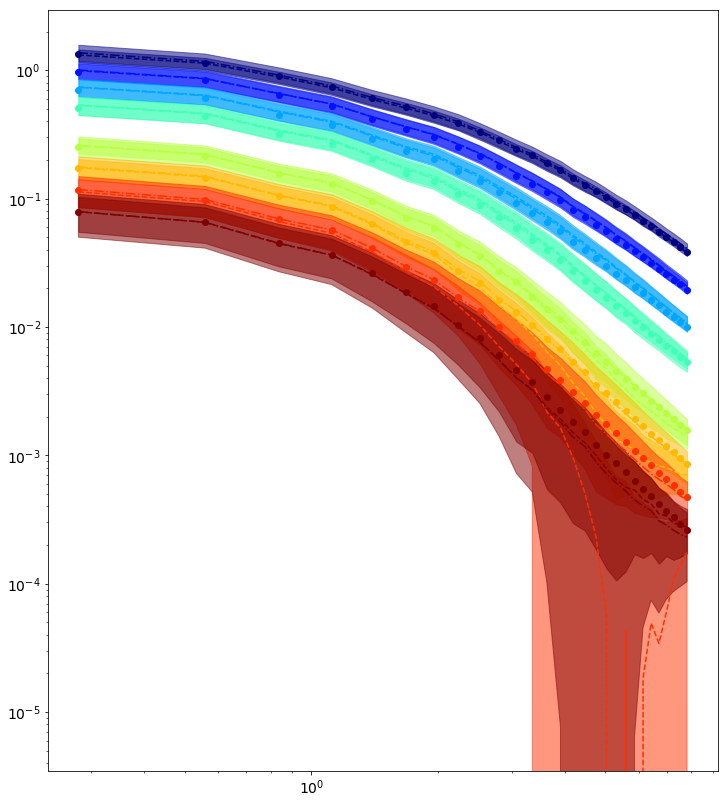

In [6]:
plt.figure(figsize=[12,14])
dex=0
for item in truth.data:
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred_z,err_z=emu_z.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_z_samepar,err_z_samepar=emu_z_parlims.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.plot(k_test,pred_z,color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_z+np.sqrt(np.diag(err_z))),
            (pred_z-np.sqrt(np.diag(err_z))),alpha=0.5,color=col)
    ## Plot z with same limits
    plt.plot(k_test,pred_z_samepar,color=col,linestyle="-.")
    plt.fill_between(k_test,(pred_z_samepar+np.sqrt(np.diag(err_z_samepar))),
            (pred_z_samepar-np.sqrt(np.diag(err_z_samepar))),alpha=0.5,color=col)
    plt.plot(k_test,item["p1d_Mpc"][1:(len(k_test)+1)],marker="o",color=col,linestyle="None")
    
    #plt.subplot(2,1,2)
    
    ## Print diffs
    #print(pred_z_samepar-pred_z)
    #print("Error diff")
    #print(np.sqrt(np.diag(err_z_samepar))-np.sqrt(np.diag(err_z)))

plt.yscale("log")
plt.xscale("log")

In [7]:
## Now want to perform the same test, with n different emulators, each using the *full* training set, but loading z-emulator
## specific hyperparmeters
emu_list=[]

for aa,emu in enumerate(emu_z.emulators):
    emu_temp=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)
    emu_temp.load_hyperparams(emu_z_parlims.emulators[aa].gp.param_array)
    emu_list.append(emu_temp)

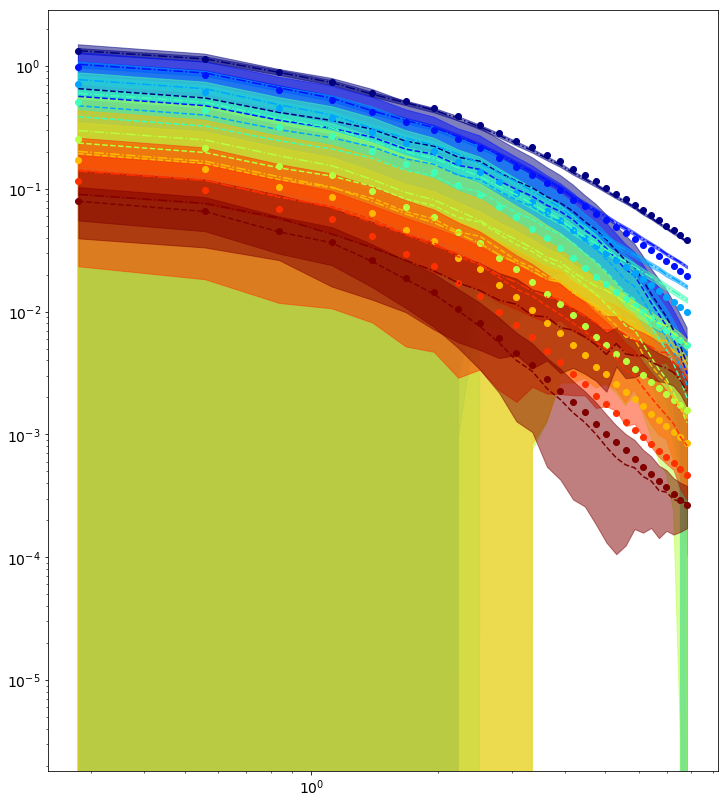

In [8]:
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    
    pred_single,err_single=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_split,err_split=emu_list[aa].emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.plot(k_test,pred_single,color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_single+np.sqrt(np.diag(err_single))),
            (pred_single-np.sqrt(np.diag(err_single))),alpha=0.5,color=col)
    ## Plot z with same limits
    plt.plot(k_test,pred_split,color=col,linestyle="-.")
    plt.fill_between(k_test,(pred_split+np.sqrt(np.diag(err_split))),
            (pred_split-np.sqrt(np.diag(err_split))),alpha=0.5,color=col)
    plt.plot(k_test,item["p1d_Mpc"][1:(len(k_test)+1)],marker="o",color=col,linestyle="None")
    

plt.yscale("log")
plt.xscale("log")

In [9]:
## Now want to train an emulator on all 200 sims, and use those hyperparameters and
## param scalings to use 199 points and predict the 1 remaining
full_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [10]:
emu_full=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 1600 points
Optimised


In [11]:
## Now want to make comparison for predicted flux power spectra before and after changing the hyperparameters
## Before

emu_fullparam=emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

emu_fullparam.paramLimits=emu_full.paramLimits
emu_fullparam.load_hyperparams(emu_full.gp.param_array)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


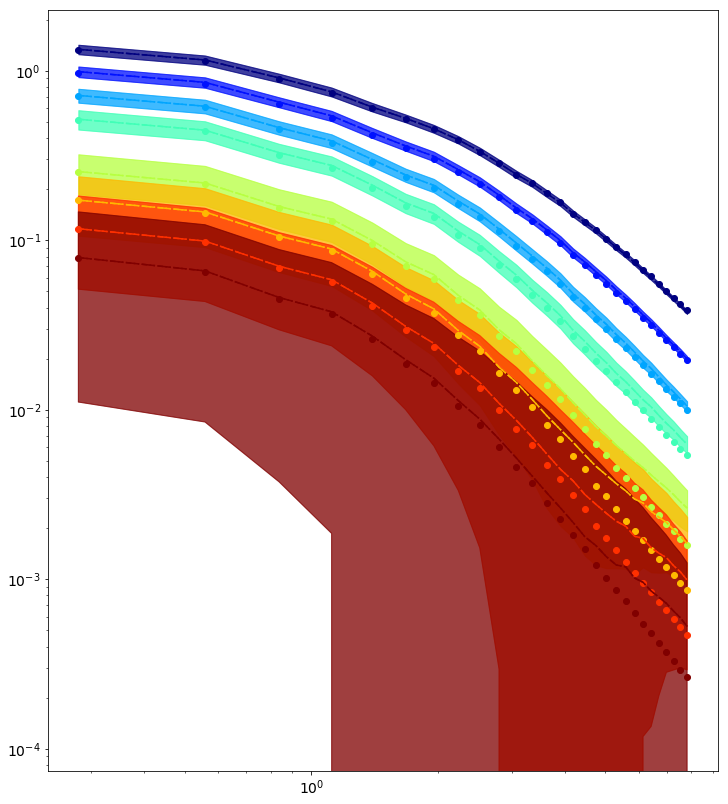

In [12]:
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    
    pred_single,err_single=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_split,err_split=emu_fullparam.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    print(pred_single-pred_split)
    ## Plot z with different limits
    plt.plot(k_test,pred_single,color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_single+np.sqrt(np.diag(err_single))),
            (pred_single-np.sqrt(np.diag(err_single))),alpha=0.5,color=col)
    ## Plot z with same limits
    plt.plot(k_test,pred_split,color=col,linestyle="-.")
    plt.fill_between(k_test,(pred_split+np.sqrt(np.diag(err_split))),
            (pred_split-np.sqrt(np.diag(err_split))),alpha=0.5,color=col)
    plt.plot(k_test,item["p1d_Mpc"][1:(len(k_test)+1)],marker="o",color=col,linestyle="None")
    

plt.yscale("log")
plt.xscale("log")

In [18]:
emu_full.gp.param_array

array([1.94038158e+01, 4.82115049e+01, 6.30520951e-01, 1.16842328e-02])

In [14]:
emu.gp.param_array

array([1.94038158e+01, 4.82115049e+01, 6.30520951e-01, 1.16842328e-02])

In [15]:
len(emu.arxiv.data)

1584

In [17]:
len(emu_fullparam.arxiv.data)

1584